# EE 25614: Neuroscience of Learning, Memory, & Cognition
## Fall 2018
## PyTorch Tutorial Assignment
### Deadline: November 2, 2018

### Name: Amirhossein Afsharrad
### Student ID: 95101077


In this assignment, you are tasked with implementing and training a simple recurrent neural network model using PyTorch. You will use this network to solve two tasks.



These are the steps you should take to complete this assignment:
1. Implement VanillaRNN class.
2. Train the network with the datasets you have generated. Visualize how loss changes through epochs.
4. Retrain the data using different sets of parameters. Report and visualize how changing each parameter changes loss. These parameters include:
    - Learning rate
    - Hidden layer size
    - Batch size
    - Number of Epochs
5. Report the parameters of your best network. Run the network on test data and visualize some examples of denoised signals the network makes.
6. Visualize activity of specific neurons through time as they process data in the parity task. Set hidden layer size to a small number for better visuals.

After completing the assignment, upload this notebook in a zip file with your student ID as its name on the CW website.

You should write all of the codes by yourself. Copying codes that are available on the internet or your classmates have written is prohibited.

If you have any questions about this assignment, please ask them on Piazza.

# Part 0: Generating datasets for two tasks.
You should write code that generates training and test datasets for each of the tasks below.


## Task 1: Predicting parity bit of a bit vector
We first define a function to create the parity-bit dataset

In [3]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import numpy as np

def parity_generator(N,L):
    X = np.random.randint(0,2,(N,L))
    Y = np.zeros((N,L))
    for i in range (L):
        Y[:,i] = np.sum(X[:,0:i+1],1)%2
    X = torch.from_numpy(X).float()
    Y = torch.from_numpy(Y).double()
    return X, Y

# testing the generator
N = 1000
L = 10
X, Y = parity_generator(N,L)
print(X[0,:])
print(Y[0,:])


tensor([0., 1., 0., 0., 1., 1., 1., 0., 1., 0.])
tensor([0., 1., 1., 1., 0., 1., 0., 0., 1., 1.], dtype=torch.float64)


## Task 2: Predicting a denoised sine wave from a noisy signal

"sine_generator" function is defined to create noisy and denoised sine wave dataset with random amplitude and zero phase.


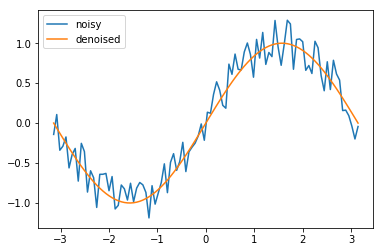

In [5]:
import matplotlib.pylab as plt


def sine_generator(N,L):
    X = np.zeros((N,L))
    Y = np.zeros((N,L))
    x = np.linspace(-np.pi, np.pi, L)
    amplitude = np.random.randn(N,1) * np.ones((N,L))
    amplitude = np.ones((N,L))
    amplitude = np.ones((N,L))*np.random.randint(1, 4, size=(N,1))
    #Y = 10*np.sin(x)*amplitude
    Y = np.sin(x)*amplitude
    X = Y + np.random.uniform(-0.3, 0.3, size=Y.shape)


    return X, Y


# testing the generator
x = np.linspace(-np.pi, np.pi, L)
N = 1000
L=100
X, Y = sine_generator(N,L)

plt.plot(x,np.array(X[120,:]), label = 'noisy')
plt.plot(x,np.array(Y[120,:]), label = 'denoised')
plt.legend()
plt.show()


# Part 1: Vanilla RNN

Equations of a forward pass in a simple RNN network looks like this:

$s_{t}=f(Ux_{t}+b_{U}+Ws_{t-1}+b_{W})$

$o_{t}=f'(Vs_{t}+b_{V})$

Where:

$s_{t}$: Hidden state of RNN at time step t.

$x_{t}$: Input at time step t.

$U$: Learnable weight matrix for connections between the hidden state and input.

$W$: Learnable weight matrix for connections between the hidden states.

$V$: Learnable weight matrix for connections between the hidden state and output.

$o_{t}$: Output at time step t.

$f$ and $f'$: Nonlineartiy functions such as tanh, ReLU, & Softmax

$b_{U}$, $b_{W}$, and $b_{V}$: Bias terms

We talked what the bias term does in the class. In practice, bias terms are not held separately. Using the bias trick, we can store $W$ and bias term of a linear model $y=Wx+b$ in a single matrix. 
![The bias trick](../media/wb.jpg)
Using the bias trick, the equations of RNN are reduce to the following:

$s_{t}=f(Ux_{t}+Ws_{t-1})$

$o_{t}=f'(Vs_{t})$

PyTorch's $nn$ module has a function for a linear models such as $y=Wx+b$. Set $f$ and $f'$ to to *tanh*.

### Vanilla RNN implementation
The following class, called RNN is created as an implementation of Vanilla RNN

In [6]:
import torch
import torch.nn as nn
from torch.autograd import Variable

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        
        self.input2hidden = nn.Linear(input_size, hidden_size)
        self.hidden2hidden = nn.Linear(hidden_size, hidden_size)
        self.hidden2output = nn.Linear(hidden_size, output_size)
        self.NonlinearFunc = nn.Tanh()
    
    def forward(self, input, hidden):
        hidden = self.input2hidden(input) + self.hidden2hidden(hidden)
        output = self.NonlinearFunc(self.hidden2output(hidden))
        return output, hidden

    def init_hidden(self):
        return Variable(torch.zeros(1, self.hidden_size))
    
    
#params = list(rnn.parameters())
#print(len(params))
#print(params[0].size())


### another implementation
The following code is a similar implementation (which won't be used in the tasks) with a little help from https://nipunbatra.github.io/blog/2018/denoising.html

In [44]:
input_dim = 1
hidden_size = 30
num_layers = 1

class RNN2(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN2, self).__init__()
        
        self.rnn = nn.RNN(input_size=input_size, hidden_size=hidden_size, batch_first=True)
        
        self.hidden2output = nn.Linear(hidden_size, output_size, )
        
        self.NonlinearFunc = nn.Tanh()
        
        
    def forward(self, x):
        output, hidden = self.rnn(x, None)
        
        output = self.NonlinearFunc(self.hidden2output(output)).view(output.data.shape[0], -1, 1)
        
        return output

r= RNN2(input_dim, hidden_size, 1)

### parity-bit RNN
the follownig function is defined to train an RNN and show the results for parity bit detection with the following parameters to be adjusted:
1. learning rate
2. hidden layer size
3. batch size
4. number of epochs
5. sequence length (optional)
6. and dataset size (optional)

In [7]:
def predictor(output):
    return (output>0.5).double()    

def parity (learning_rate, hidden_size, batch_size, number_of_epochs, sequence_length=10, dataset_size = 100):

    rnn = RNN(input_size=1, hidden_size=hidden_size, output_size=1)
    
    L = sequence_length
    
    N = dataset_size
    
    num_of_batches = int(N/batch_size)
    
    input, target = parity_generator(N,L)
    
    epochs_samples = np.zeros(int(number_of_epochs/20))
    
    epoch_loss = np.zeros(int(number_of_epochs/20))


    for epochs in range(number_of_epochs):
        criterion = nn.MSELoss()

        learning_rate = 0.005

        optimizer = torch.optim.SGD(rnn.parameters(), lr=learning_rate)
      #  optimizer = torch.optim.Adam(rnn.parameters(), lr=learning_rate)

        OUT = torch.tensor(np.zeros((batch_size, L)))

        rnn.zero_grad()

        for k in range (num_of_batches):
            for i in range (batch_size):
                hidden = rnn.init_hidden()
                for j in range (L):
                    output, hidden = rnn(input[k*batch_size+i,j].unsqueeze(0), hidden)
                    OUT[i,j] = output
                    #loss += criterion(output.double(), target[k*batch_size+i,j].unsqueeze(0).unsqueeze(0))
        loss = criterion(OUT.double(), target[k*batch_size:(k+1)*batch_size,:])
        loss.backward()
        optimizer.step()
        
        
        if (epochs%20==0):
            print('epoch=',epochs, ', loss=', loss.item())
            number = int(epochs/20)
            epochs_samples[number] = epochs
            epoch_loss[number] = loss.item()

    predictedOUT = predictor(OUT)
    print(predictedOUT.numpy().squeeze())
    plt.figure
    plt.subplot(2,1,1)
    plt.plot(OUT.detach().numpy()[-1,:],label='out')
    plt.plot(predictedOUT.numpy().squeeze(),label='pout')
    plt.plot(input.detach().numpy()[-1,:],label='in')
    plt.plot(target.detach().numpy()[-1,:],label='target')
    plt.legend()
    plt.subplot(2,1,2)
    plt.plot(epochs_samples, epoch_loss)
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.show()
    
    hidden = rnn.init_hidden()
    O = torch.tensor(np.zeros(L))
    Hidden = torch.tensor(np.zeros((L,hidden_size,10)))
    for test in range (10):
        hidden = rnn.init_hidden()
        for i in range (L):
            rnn.zero_grad()
            output, hidden = rnn(input[N-10+test,i].unsqueeze(0), hidden)
            Hidden[i,:,test] = hidden
            O[i] = output

    plt.figure
    plt.imshow(np.array(input[N-10:N,:]).T)
    plt.title('input')
    plt.show()

    for unit in range(hidden_size):
        Hid = np.array(Hidden[:,unit,:].detach().numpy())
        plt.figure
        plt.imshow(Hid.T)
        plt.title('neural activity')
        plt.show()

    OUTPUT = predictor(O)
    E = abs(OUTPUT-target[N-1,:])
    print('percentage=',(100-100*torch.sum(E)/(L)).item())

        
    return


Now we shall test the network with different parameters
### Learning Rate

In [ ]:
parity (learning_rate=0.001, hidden_size=4, batch_size=50, number_of_epochs=1000, sequence_length=10, dataset_size = 100)

epoch= 0 , loss= 0.3061099614464008
epoch= 20 , loss= 0.2971665185466616
epoch= 40 , loss= 0.2902876473592348
epoch= 60 , loss= 0.28474757718097105
epoch= 80 , loss= 0.2802032661685999
epoch= 100 , loss= 0.27642904067469376
epoch= 120 , loss= 0.2732614656156914
epoch= 140 , loss= 0.2705781829539663
epoch= 160 , loss= 0.268285982484014
epoch= 180 , loss= 0.26631287846754426
epoch= 200 , loss= 0.26460256325218734
epoch= 220 , loss= 0.2631105792544104
epoch= 240 , loss= 0.26180144986103854
epoch= 260 , loss= 0.26064659240550897
epoch= 280 , loss= 0.259622744716346
epoch= 300 , loss= 0.25871093484863283
epoch= 320 , loss= 0.25789543048993685
epoch= 340 , loss= 0.2571632028577159
epoch= 360 , loss= 0.2565033270045534
epoch= 380 , loss= 0.25590663103602235
epoch= 400 , loss= 0.255365316435627
epoch= 420 , loss= 0.2548727813368417
epoch= 440 , loss= 0.2544233652922375
epoch= 460 , loss= 0.25401218741951737
epoch= 480 , loss= 0.25363505886150695
epoch= 500 , loss= 0.253288332590747
epoch= 520 

In [ ]:
parity (learning_rate=0.005, hidden_size=4, batch_size=50, number_of_epochs=1000, sequence_length=10, dataset_size = 100)

In [ ]:
parity (learning_rate=0.02, hidden_size=4, batch_size=50, number_of_epochs=1000, sequence_length=10, dataset_size = 100)

In [ ]:
parity (learning_rate=0.1, hidden_size=4, batch_size=50, number_of_epochs=1000, sequence_length=10, dataset_size = 100)

In [ ]:
parity (learning_rate=0.001, hidden_size=4, batch_size=50, number_of_epochs=1000, sequence_length=10, dataset_size = 100)

In [ ]:
parity (learning_rate=0.001, hidden_size=4, batch_size=50, number_of_epochs=1000, sequence_length=10, dataset_size = 100)

In [ ]:
parity (learning_rate=0.001, hidden_size=4, batch_size=50, number_of_epochs=1000, sequence_length=10, dataset_size = 100)

In [ ]:
parity (learning_rate=0.001, hidden_size=4, batch_size=50, number_of_epochs=1000, sequence_length=10, dataset_size = 100)

In [ ]:
parity (learning_rate=0.001, hidden_size=4, batch_size=50, number_of_epochs=1000, sequence_length=10, dataset_size = 100)

In [ ]:
parity (learning_rate=0.001, hidden_size=4, batch_size=50, number_of_epochs=1000, sequence_length=10, dataset_size = 100)

In [ ]:
parity (learning_rate=0.001, hidden_size=4, batch_size=50, number_of_epochs=1000, sequence_length=10, dataset_size = 100)

In [ ]:
parity (learning_rate=0.001, hidden_size=4, batch_size=50, number_of_epochs=1000, sequence_length=10, dataset_size = 100)

In [ ]:
parity (learning_rate=0.001, hidden_size=4, batch_size=50, number_of_epochs=1000, sequence_length=10, dataset_size = 100)

In [ ]:
parity (learning_rate=0.001, hidden_size=4, batch_size=50, number_of_epochs=1000, sequence_length=10, dataset_size = 100)

In [ ]:
parity (learning_rate=0.001, hidden_size=4, batch_size=50, number_of_epochs=1000, sequence_length=10, dataset_size = 100)

In [ ]:
parity (learning_rate=0.001, hidden_size=4, batch_size=50, number_of_epochs=1000, sequence_length=10, dataset_size = 100)

In [48]:
import matplotlib.pylab as plt
number_of_epochs = 1000
number_of_tests = 20
input, target = parity_generator(number_of_tests,L)

hidden = rnn.init_hidden()
O = torch.tensor(np.zeros(L))
Hidden = torch.tensor(np.zeros((L,hidden_size,number_of_tests)))
for test in range (number_of_tests):
    for i in range (L):
        rnn.zero_grad()
        output, hidden = rnn(input[test,i].unsqueeze(0), hidden)
        Hidden[i,:,test] = hidden
        O[i] = output
for unit in range(hidden_size):
    Hid = np.array(Hidden[:,unit,:].detach().numpy())
    plt.figure
    plt.imshow(Hid.T)
    plt.show()
#print(loss)
OUTPUT = predictor(O)
E = abs(OUTPUT-target)
print(E)
#print(OUTPUT)
print(1-torch.sum(E)/(L*number_of_tests))
#print((((predictor(O)).float()-(target==1).float)))
#print(.sum().float()/L)

        #return output, loss.data[0]

NameError: name 'rnn' is not defined

In [35]:
def denoising (learning_rate, hidden_size, batch_size, number_of_epochs, number_of_time_samples=30, dataset_size = 100):

    rnn = RNN(input_size=1, hidden_size=hidden_size, output_size=1)

    L = number_of_time_samples
    N = dataset_size

    num_of_batches = int(N/batch_size)

    input, target = sine_generator(N,L)
    input = torch.tensor(input)
    target = torch.tensor(target)
    
    epochs_samples = np.zeros(int(number_of_epochs/20))
    
    epoch_loss = np.zeros(int(number_of_epochs/20))

    for epochs in range(number_of_epochs):
        criterion = nn.MSELoss()

        optimizer = torch.optim.SGD(rnn.parameters(), lr=learning_rate)
      #  optimizer = torch.optim.Adam(rnn.parameters(), lr=learning_rate)

        OUT = torch.tensor(np.zeros((batch_size, L)))

        rnn.zero_grad()

        for k in range (num_of_batches):
            for i in range (batch_size):
                hidden = rnn.init_hidden()
                for j in range (L):
                    output, hidden = rnn(input[k*batch_size+i,j].float().unsqueeze(0), hidden.float())
                    OUT[i,j] = output
                    #loss += criterion(output.double(), target[k*batch_size+i,j].unsqueeze(0).unsqueeze(0))
        loss = criterion(OUT.double(), target[k*batch_size:(k+1)*batch_size,:])
        loss.backward()
        optimizer.step()

        if (epochs%20==0):
            print('epoch=',epochs, ', loss=', loss.item())
            number = int(epochs/20)
            epochs_samples[number] = epochs
            epoch_loss[number] = loss.item()


    plt.figure
    plt.subplot(2,1,1)
    plt.plot(OUT.detach().numpy()[-1,:],label='out')
    plt.plot(input.detach().numpy()[-1,:],label='in')
    plt.plot(target.detach().numpy()[-1,:],label='target')
    plt.legend()
    plt.subplot(2,1,2)
    plt.plot(epochs_samples, epoch_loss)
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.show()
    
    return



epoch= 0 , loss= 1.9832684900594868
epoch= 20 , loss= 0.6223844295924875
epoch= 40 , loss= 0.6004614260539546
epoch= 60 , loss= 0.5917778004304555
epoch= 80 , loss= 0.5874155108705548


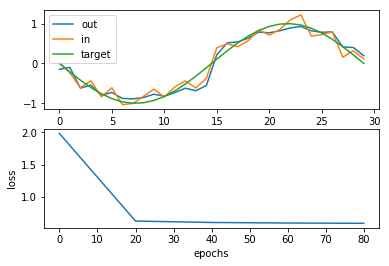

In [36]:
denoising(learning_rate = 0.05, hidden_size = 4, batch_size = 50, number_of_epochs = 100)

In [84]:
input_dim = 1
hidden_size = 30
num_layers = 1

class CustomRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(CustomRNN, self).__init__()
        self.rnn = nn.RNN(input_size=input_size, hidden_size=hidden_size, batch_first=True)
        self.linear = nn.Linear(hidden_size, output_size, )
        self.act = nn.Tanh()
    def forward(self, x):
        pred, hidden = self.rnn(x, None)
        pred = self.act(self.linear(pred)).view(pred.data.shape[0], -1, 1)
        return pred

r= CustomRNN(input_dim, hidden_size, 1)

In [88]:
input_dim = 1
hidden_size = 30
num_layers = 1

class RNN2(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN2, self).__init__()
        self.rnn = nn.RNN(input_size=input_size, hidden_size=hidden_size, batch_first=True)
        self.hidden2output = nn.Linear(hidden_size, output_size, )
        self.NonlinearFunc = nn.Tanh()
    def forward(self, x):
        output, hidden = self.rnn(x, None)
        output = self.NonlinearFunc(self.hidden2output(output)).view(output.data.shape[0], -1, 1)
        return output

r= RNN2(input_dim, hidden_size, 1)

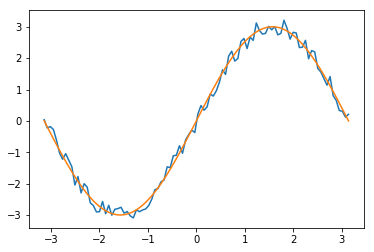

In [152]:
# Generating a clean sine wave 
def sine(X, signal_freq=60.):
    return np.sin(2 * np.pi * (X) / signal_freq)

# Adding uniform noise
def noisy(Y, noise_range=(-0.35, 0.35)):
    noise = np.random.uniform(noise_range[0], noise_range[1], size=Y.shape)
    return Y + noise

# Create a noisy and clean sine wave 
def sample(sample_size):
    random_offset = np.random.randint(0, sample_size)
    X = np.arange(sample_size)
    out = sine(X + random_offset)
    inp = noisy(out)
    return inp, out




In [81]:
def create_dataset(n_samples=10000, sample_size=100):
    data_inp = np.zeros((n_samples, sample_size))
    data_out = np.zeros((n_samples, sample_size))
    
    for i in range(n_samples):
        sample_inp, sample_out = sample(sample_size)
        data_inp[i, :] = sample_inp
        data_out[i, :] = sample_out
    return data_inp, data_out

In [82]:
data_inp, data_out = create_dataset()
train_inp, train_out = data_inp[:8000], data_out[:8000]
test_inp, test_out = data_inp[8000:], data_out[8000:]

In [153]:
# Storing predictions per iterations to visualise later
predictions = []

optimizer = torch.optim.Adam(r.parameters(), lr=1e-2)
loss_func = nn.L1Loss()
train_inp, train_out = sine_generator(10000,100)
for t in range(301):
    hidden = None
    inp = Variable(torch.Tensor(train_inp.reshape((train_inp.shape[0], -1, 1))), requires_grad=True)
    out = Variable(torch.Tensor(train_out.reshape((train_out.shape[0], -1, 1))) )
    pred = r(inp)
    optimizer.zero_grad()
    predictions.append(pred.data.numpy())
    loss = loss_func(pred, out)
    if t%20==0:
        print(t, loss.data[0])
    loss.backward()
    optimizer.step()

/home/amirhossein/.local/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  app.launch_new_instance()


0 tensor(0.5313)
20 tensor(0.5311)
40 tensor(0.5235)
60 tensor(0.5183)
80 tensor(0.5154)
100 tensor(0.5139)
120 tensor(0.5136)
140 tensor(0.5129)
160 tensor(0.5116)
180 tensor(0.5130)
200 tensor(0.5086)
220 tensor(0.5361)
240 tensor(0.5166)
260 tensor(0.5131)
280 tensor(0.5132)
300 tensor(0.5099)


tensor(0.1062)


/home/amirhossein/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  after removing the cwd from sys.path.


Text(0.5, 1.0, 'Sample num: 23')

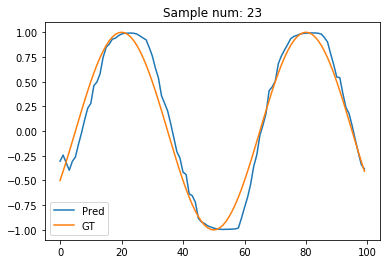

In [156]:
t_inp = Variable(torch.Tensor(test_inp.reshape((test_inp.shape[0], -1, 1))), requires_grad=True)
pred_t = r(t_inp)
# Test loss
print(loss_func(pred_t, Variable(torch.Tensor(test_out.reshape((test_inp.shape[0], -1, 1))))).data[0])
sample_num = 23
plt.plot(pred_t[sample_num].data.numpy(), label='Pred')
plt.plot(test_out[sample_num], label='GT')
plt.legend()
plt.title("Sample num: {}".format(sample_num))